In [1045]:
##External
import numpy as np
import pandas as pd
from pprint import pprint
import os
import re
from datasets import Dataset, load_from_disk
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, DataCollatorForTokenClassification
import torch

#import nltk
#from nltk.tokenize import sent_tokenize, word_tokenize, TreebankWordTokenizer, WhitespaceTokenizer
#import textwrap
#nltk.download('punkt')

#Internal
import data_cleaning.data_cleaning as dc

# 1. Data Preparation
We will start by opening our dataset and formatting it for the training step.
<br>


## Opening the UFRGS Documents dataset
The easiest way to use our data with HuggingFace is to use the datasets library. It allows us to import our own data and it will format it into a Dataset Object that is ready to be used by the NER model.

In the 03_make_dataset notebook we already saved our annotated dataset as a HuggingFace Dataset. Now we need to open it to start prepping it from the training workflow.

In [1046]:
ner_dataset = load_from_disk("../data/annotated/ufrgs_documents_13-06-25")
ner_dataset

Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 676
})

In [1047]:
#pprint(ner_dataset['id'][3])
print(ner_dataset['tokens'][5])
print(ner_dataset['ner_tags'][5])

['Autorizar', 'o', 'afastamento', 'do', 'país', 'de', 'RAFAEL', 'ROESLER', ',', 'Professor', 'do', 'Maigstério', 'Superior', ',', 'lotado', 'e', 'em', 'exercício', 'no', 'Departamento', 'de', 'Farmacologia', 'do', 'Instituto', 'de', 'Ciências', 'Básicas', 'da', 'Saúde', ',', 'com', 'a', 'finalidade', 'de', 'participar', 'de', 'reunião', 'na', 'University', 'of', 'Nottingham', '-', 'Inglaterra', ',', 'no', 'período', 'compreendido', 'entre', '02/09/2016', 'e', '10/09/2016', ',', 'com', 'limitado', '.']
[0, 0, 0, 0, 0, 0, 1, 2, 0, 9, 10, 10, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, 5, 0, 0, 0, 0, 0, 7, 0, 7, 0, 0, 0, 0]


## Splitting dataset into train and test
We'll split our DataFrame into to lists of lists. One for the input tokens and another for the labels.
After that we'll use the scklearn train_test_split method to get both our train and test data.

In [1048]:
# Split X and y into train and test.
split_dataset = ner_dataset.train_test_split(test_size=0.33, seed=43)
print(split_dataset)

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 452
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 224
    })
})


## Visualizing the label distribution in test and train

Number of samples in train set: 452
Amount of each label in the dataset:
8     1854
2     1608
7     1326
10     873
1      653
9      652
4      619
3      297
5      106
6       65
Name: count, dtype: int64
bar graph of labels:


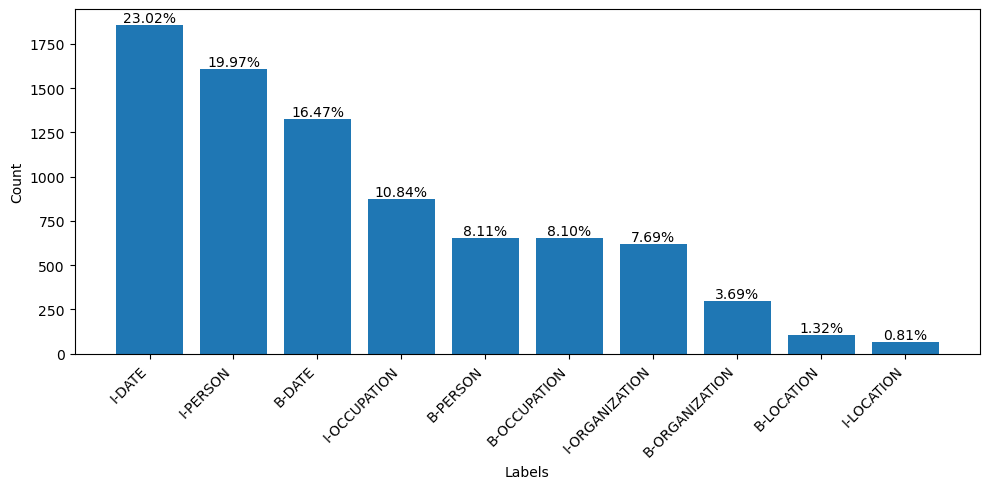

Number of samples in test set: 224
Amount of each label in the dataset:
8     988
2     723
7     619
10    461
4     381
9     330
1     295
3     183
5      47
6      19
Name: count, dtype: int64
bar graph of labels:


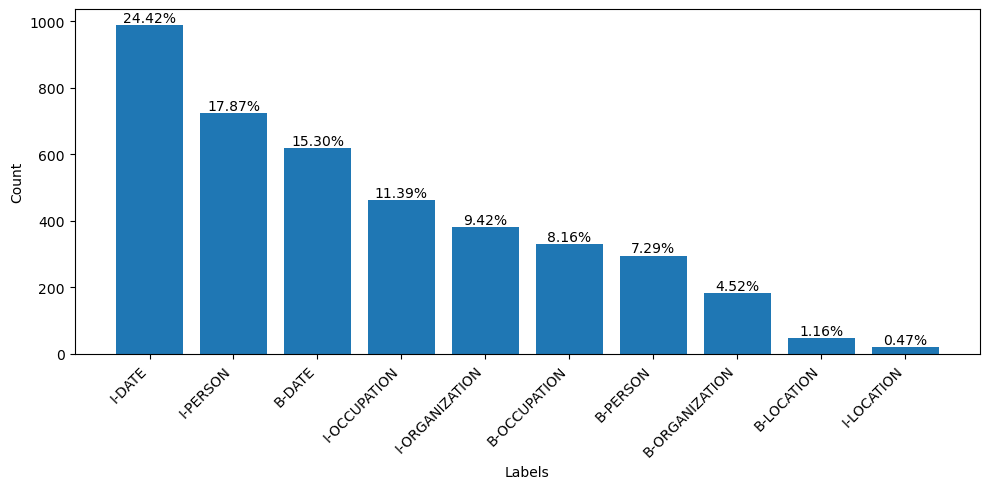

In [1049]:
id_to_label = {
    0: 'O',
    1: 'B-PERSON',
    2: 'I-PERSON',
    3: 'B-ORGANIZATION',
    4: 'I-ORGANIZATION',
    5: 'B-LOCATION',
    6: 'I-LOCATION',
    7: 'B-DATE',
    8: 'I-DATE',
    9: 'B-OCCUPATION',
    10: 'I-OCCUPATION'
}

for split in ['train', 'test']:
    print(f"Number of samples in {split} set: {len(split_dataset[split])}")
    label_series = pd.Series(split_dataset[split]['ner_tags']).explode()
    label_series = label_series[label_series != 0]  # Remove padding labels
    print("Amount of each label in the dataset:")
    print(label_series.value_counts())
    print("bar graph of labels:")
    plt.figure(figsize=(10, 5))
    
    # Convert numeric labels to string labels for plotting
    label_counts = label_series[label_series != 0].value_counts()
    label_names = [id_to_label[label_id] for label_id in label_counts.index]
    
    # Make a bar graph of the labels
    plt.bar(label_names, label_counts.values)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
    
    # Add percentage on top of each bar
    for i, v in enumerate(label_series[label_series != "O"].value_counts()):
        plt.text(i, v + 0.5, f"{v/label_series[label_series != "O"].size*100:.2f}%", ha='center', va='bottom')
        
    plt.tight_layout()  # Adjust layout to prevent label cutoff
    plt.show()

## Load experiment parameters

In [1050]:
# Load list of experiments into a DataFrame
experiments_df = pd.read_csv("../data/experiments_definition/Experiments.csv")
experiments_df = experiments_df[12:] # Keep only the parameter optimization experiments
experiments_df = experiments_df.reset_index(drop=True)

active_exp =  experiments_df.iloc[11] # Index of the experiment to run
#Define experiment parameters
experiment_id = f'{active_exp["Experimento"]}-{active_exp['Model-Parameter Set']}'
n_of_epochs = active_exp['EPOCHS']
batch_size = int(active_exp['BATCH SIZE'])
learning_rate = active_exp['Learning Rate']
dropout = active_exp['Dropout']
base_model = 'bert-base-multilingual-uncased'

#checkpoint = 'neuralmind/bert-base-portuguese-cased'
checkpoint = base_model


print('Experiment ID', experiment_id,
      '\nNumber of epochs:', n_of_epochs,
      '\nBatch size:', batch_size,
      '\nLearning rate:', learning_rate,
      '\nDropout:', dropout,
      '\nBase model:', base_model)

print(type(batch_size))

Experiment ID exp24-m5-s12 
Number of epochs: 10 
Batch size: 8 
Learning rate: 5e-05 
Dropout: 0.3 
Base model: bert-base-multilingual-uncased
<class 'int'>


In [1051]:
active_exp

Experimento              exp24
Model-Parameter Set     m5-s12
EPOCHS                      10
BATCH SIZE                   8
Learning Rate          0.00005
Dropout                    0.3
Warmup Steps               0.1
Name: 11, dtype: object

In [1052]:
experiments_df

,Experimento,Model-Parameter Set,EPOCHS,BATCH SIZE,Learning Rate,Dropout,Warmup Steps
0,exp13,m5-s1,5,8,0.00001,0.1,0.1
1,exp14,m5-s2,5,8,0.00001,0.3,0.1
2,exp15,m5-s3,5,8,0.00002,0.1,0.1
3,exp16,m5-s4,5,8,0.00002,0.3,0.1
4,exp17,m5-s5,5,8,0.00005,0.1,0.1
5,exp18,m5-s6,5,8,0.00005,0.3,0.1
6,exp19,m5-s7,10,8,0.00001,0.1,0.1
7,exp20,m5-s8,10,8,0.00001,0.3,0.1
8,exp21,m5-s9,10,8,0.00002,0.1,0.1
9,exp22,m5-s10,10,8,0.00002,0.3,0.1


## Tokenization: Sub-word convertion
We create a tokenizer to convert our inputs into sub-word ids. We need to use a tokenizer that is compatible with the model we'll use.
HuggingFace makes that easy through the AutoTokenizer, which allows us to specify which model will be used and it already makes sure that our tokenizer will work with it.


In [1053]:
checkpoint = base_model
tokenizer = AutoTokenizer.from_pretrained(checkpoint, add_prefix_space=True) #add_prefix_space=True for RoBERTa tokenizer compatibility

# Print the labels in checkpoint
print("Labels in checkpoint:")
for i in range(len(tokenizer.get_vocab())):
    if i in id_to_label:
        print(f"{i}: {id_to_label[i]}")


Labels in checkpoint:
0: O
1: B-PERSON
2: I-PERSON
3: B-ORGANIZATION
4: I-ORGANIZATION
5: B-LOCATION
6: I-LOCATION
7: B-DATE
8: I-DATE
9: B-OCCUPATION
10: I-OCCUPATION


### Testing the sub-word tokenizer

In [1054]:
# We use one of the samples to test the tokenizer
testenizer = tokenizer(split_dataset['train'][8]['tokens'], is_split_into_words=True)

#The tokenizer return looks like a dictionary but it is actually an object called BatchEncoding
print(type(testenizer), '\n')

#print each key in the tokenizer object
print("")
for key in testenizer.keys():
    print(f"{key}: {len(testenizer[key])} entries {testenizer[key]}")
print('\n')

#The object has a tokens method that returns the original tokens before transforming them into integers
# The word_ids methods returns a list with the ID that maps each sub-word to the original word it was tokenized from.
for item1, item2 in zip(testenizer.word_ids(), testenizer.tokens()):
    print(f"{item1} {item2}")

<class 'transformers.tokenization_utils_base.BatchEncoding'> 


input_ids: 77 entries [101, 17757, 10370, 157, 11460, 10177, 83300, 10132, 117, 143, 11736, 10102, 10280, 10102, 20185, 10102, 10520, 117, 10102, 47773, 37744, 10112, 13997, 11732, 10892, 117, 12152, 18754, 13426, 13162, 11599, 22680, 86141, 11518, 68547, 11124, 117, 28905, 11223, 10154, 15524, 10102, 10133, 27776, 51792, 147, 15476, 11251, 117, 10141, 13096, 10102, 56551, 39159, 62571, 14135, 10141, 43898, 10111, 10239, 157, 84858, 10102, 28036, 22565, 10141, 12278, 28008, 15387, 11401, 10102, 56551, 39159, 62571, 14135, 119, 102]
token_type_ids: 77 entries [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
attention_mask: 77 entries [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

### Target Alignment
Once we tokenize our input in sub-words, we'll need to make sure that there is one target per sub-word. <br>
To do this we will use the **align_targets** function to remap ou targets correctly.

In [1055]:
#Define relationship between B and I tags
begin2inside = {
    1: 2,   # B-PERSON -> I-PERSON
    3: 4,   # B-ORGANIZATION -> I-ORGANIZATION  
    5: 6,   # B-LOCATION -> I-LOCATION
    7: 8,   # B-DATE -> I-DATE
    9: 10   # B-OCCUPATION -> I-OCCUPATION 
}

# Function that aligns the labels to be correctly associated with each sub-word.
def align_targets(labels, word_ids):
    aligned_labels = []
    previous_word = None

    for word in word_ids:
        if word is None: # Tokens like [CLS] and [SEP]
            label = -100 # Standard HuggingFace value for ignored tokens while training
            
        elif word != previous_word:  # New word in the list
            label = labels[word]
            
        else:
            if labels[word] in begin2inside: # Repeated word (Would be the next sub-word)
                label = begin2inside[labels[word]] # Change B- to I-
                
            else: # Sub-word of a word classified as "O" gets the same label "O" and Sub-word of a word classified as "B-" gets the same label "B-"
                label = labels[word]

        aligned_labels.append(label)
        previous_word = word #update last word
 
    return aligned_labels

In [1056]:
## Label-Token Alignment Test
idx = 1
test_data = tokenizer(split_dataset['train'][idx]['tokens'], is_split_into_words=True)
print("Tokenized Data:", test_data)
print("Word Tokens:", split_dataset['train'][idx]['tokens'])
test_labels = split_dataset['train'][idx]['ner_tags']
print("Word Labels:", test_labels)
print("Word IDs:", test_data.word_ids())
aligned_targets = align_targets(test_labels, test_data.word_ids())
print("Sub-Word Labels:", aligned_targets)
print("Sub-Word Tokens:", test_data.tokens())

Tokenized Data: {'input_ids': [101, 31656, 15993, 157, 10513, 26604, 11605, 10154, 11893, 10102, 56456, 10273, 15274, 42140, 117, 12156, 10154, 43127, 10625, 14331, 117, 15632, 11511, 147, 10252, 11460, 10177, 83300, 10132, 10181, 13096, 10102, 49984, 87372, 10154, 13149, 10102, 25197, 117, 10241, 143, 63785, 17182, 10102, 23177, 26792, 143, 12404, 118, 12251, 118, 12663, 56439, 118, 11450, 11388, 117, 10252, 56439, 117, 29798, 117, 10181, 12659, 85065, 28635, 21155, 10351, 10405, 10710, 120, 10710, 120, 10520, 147, 10304, 120, 10710, 120, 10520, 117, 47834, 66280, 117, 10241, 20912, 10107, 84622, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [1057]:
# aligned_labels = [target_labels[t] if t>=0 else None for t in aligned_targets]
# for x, y in zip(test_data.tokens(), aligned_labels):
#     print(f"{x}\t{y}")

### Tokenize inputs
We take the sub-word inputs and labels and pass it to the 'tokenize_fn' function to generate the tokens we'll feed to the model.

In [1058]:
# Function to tokenize both inputs and targets
def tokenize_fn(batch):
    # Tokenize the input sequence first
    tokenized_inputs = tokenizer(batch['tokens'], truncation=True, is_split_into_words=True, max_length=512)
    
    # The original targets word-by-word
    labels_batch = batch['ner_tags']
    aligned_labels_batch = []

    # Loop through each sequence in the batch
    for i, labels in enumerate(labels_batch):
        word_ids = tokenized_inputs.word_ids(i) # Get word IDs for the sequence
        aligned_labels_batch.append(align_targets(labels, word_ids)) # Align sequence labels
    
    # Save final aligned labels in a column called 'labels' which is the required name for the hugging face models
    tokenized_inputs['labels'] = aligned_labels_batch
    
    return tokenized_inputs

In [1059]:
split_dataset['train']

Dataset({
    features: ['tokens', 'ner_tags'],
    num_rows: 452
})

In [1060]:
# Use the datasets method 'map' to apply the tokenize function to the train and test datasets.
# We'll use the batched parameter to improve the eficiency of the tokenization.
tokenized_datasets = split_dataset.map(
	tokenize_fn,
	batched=True,
	remove_columns=split_dataset["train"].column_names
)

In [1061]:
tokenized_datasets
train_dataset = tokenized_datasets['train']
test_dataset = tokenized_datasets['test']

print("Train Dataset:", train_dataset)
print("Test Dataset:", test_dataset)

Train Dataset: Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 452
})
Test Dataset: Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 224
})


### Test the DataCollator
There are several required steps before passing the text into the model: padding, truncate, converting to tensors, etc. When we use the tokenizer method we are not doing most of these steps because the ‘data collator’ in the trainer is taking care of it implicitly when we train the model.

The Data Collator is built into the trainer and is defined as such:

> • **data_collator** (`DataCollator`, *optional*) — The function to use to form a batch from a list of elements of `train_dataset` or `eval_dataset`. Will default to **[default_data_collator()](https://huggingface.co/docs/transformers/v4.22.1/en/main_classes/data_collator#transformers.default_data_collator)** if no `tokenizer` is provided, an instance of **[DataCollatorWithPadding](https://huggingface.co/docs/transformers/v4.22.1/en/main_classes/data_collator#transformers.DataCollatorWithPadding)** otherwise.
> 

#### For Token Classification

The Trainer object in Hugging Face is not capable of recognizing which task we are trying to execute and therefore is not able to automatically select the correct Data Collator for us. Since the default DataCollatorWithPadding does not support tasks of the token classification type, we’ll need to manually define the one we want by importing the token classification data collator.

In [1062]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
data_collator

DataCollatorForTokenClassification(tokenizer=BertTokenizerFast(name_or_path='bert-base-multilingual-uncased', vocab_size=105879, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
), padding=True, max_length=None, pad_to_multiple_of=None, label_pad_

In [1063]:
# Test the data collator. It should return both inputs as tensor of the same size (including the padding).
collator_testset = [tokenized_datasets["train"][i] for i in range(2)]
batch = data_collator(collator_testset)
#batch["labels"]

### Metrics for validation
Computing metrics isn’t as straight forward when we deal with multiple targets per sample(sentence). Usually when calculating accuracy with a single target we can do #correct_samples/#total_samples. This is not possible when each sample has several targets.
One solution would be flattening all predictions to calculate #correct_targets/#total_targets.
#### Seqeval
This library is the standard method to calculate metrics in hugging face as its sole purpose is to compute metrics for NLP tasks with sequence targets.\
https://huggingface.co/spaces/evaluate-metric/seqeval

In [1064]:
#from datasets import load_metric
#metric = load_metric("seqeval")
import evaluate
metric = evaluate.load("seqeval")

In [1065]:
# Seqeval supports sequence labeling evalutation with the IOB formats. So to get rid of the warning and correctly compute the metrics we need to follow this formatting standard.
# metric.compute(
#     predictions=[['I-ORG', 'I-ORG', 'B-ORG', 'I-ORG', 'B-LOC'], ['B-MISC', 'B-ORG', 'B-PER', 'I-PER', "I-MISC", 'B-ORG', 'I-ORG', 'B-ORG', 'I-ORG', 'O']], 
#     references=[['O', 'B-LOC', 'B-ORG', 'I-ORG', 'I-ORG'], ['B-MISC', 'I-MISC', 'B-PER', 'I-PER', 'O', 'B-MISC', 'I-MISC', 'B-PER', 'I-PER', 'O']])

In [1066]:
label_names = [id_to_label[i] for i in range(len(id_to_label))]
print("Label Names:", label_names)

def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    preds = np.argmax(logits, axis=-1)

    # remove -100, convert the label ids to label names
    str_labels = [[label_names[t] for t in label if t != -100] for label in labels]

    # do the same for predictions whenever true label is -100
    str_preds = [[label_names[p] for p, t in zip(pred, targ) if t != -100] for pred, targ in zip(preds, labels)]

    the_metrics = metric.compute(predictions=str_preds, references=str_labels)
        
    # Debug: Print what seqeval actually found
    print("Seqeval found these entity types:", [k for k in the_metrics.keys() if k not in ['overall_precision', 'overall_recall', 'overall_f1', 'overall_accuracy']])
    
    # Start with overall metrics
    result = {
        'precision': the_metrics.get('overall_precision', 0.0),
        'recall': the_metrics.get('overall_recall', 0.0), 
        'f1': the_metrics.get('overall_f1', 0.0),
        'accuracy': the_metrics.get('overall_accuracy', 0.0),
    }
    
    # Add ALL entity-specific metrics that seqeval computed
    for key, value in the_metrics.items():
        if key not in ['overall_precision', 'overall_recall', 'overall_f1', 'overall_accuracy']:
            result[key] = value
                
    return result
    


Label Names: ['O', 'B-PERSON', 'I-PERSON', 'B-ORGANIZATION', 'I-ORGANIZATION', 'B-LOCATION', 'I-LOCATION', 'B-DATE', 'I-DATE', 'B-OCCUPATION', 'I-OCCUPATION']


In [1067]:
id2label = {k: v for k, v in enumerate(label_names)} #Get label IDs
label2id = {v: k for k, v in id2label.items()} #Get label names from IDs
print(id2label)
print(label2id)

{0: 'O', 1: 'B-PERSON', 2: 'I-PERSON', 3: 'B-ORGANIZATION', 4: 'I-ORGANIZATION', 5: 'B-LOCATION', 6: 'I-LOCATION', 7: 'B-DATE', 8: 'I-DATE', 9: 'B-OCCUPATION', 10: 'I-OCCUPATION'}
{'O': 0, 'B-PERSON': 1, 'I-PERSON': 2, 'B-ORGANIZATION': 3, 'I-ORGANIZATION': 4, 'B-LOCATION': 5, 'I-LOCATION': 6, 'B-DATE': 7, 'I-DATE': 8, 'B-OCCUPATION': 9, 'I-OCCUPATION': 10}


#### Load the pre-trained model

We use the AutoModelForTokenClassification.from_pretrained method to load the BERT model from huggingface.\
The model loades will be the one defined by 'checkpoint'.\
We pass the id2label and label2id parameters for the model to understand the targets we are using for the prediction and training.

In [1068]:
from transformers import AutoModelForTokenClassification

In [1069]:
model = AutoModelForTokenClassification.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    
    # Dropout for regularization
    classifier_dropout=dropout,    # Default is usually 0.1    
    
    # Handle size mismatches when fine-tuning
    ignore_mismatched_sizes=False,  # Set to True if adapting from different num_labels
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Create the Training Arguments
The training arguments define several parameters of how the training of the model will happen. Some argument define where the outputs will be save, how often during training we want to compute metric, how many epochs we will use for training, define the learning rate and many others. There are a several arguments which can all be found in the documentation of the function:

[https://huggingface.co/docs/transformers/v4.21.1/en/main_classes/trainer#transformers.TrainingArguments](https://huggingface.co/docs/transformers/v4.21.1/en/main_classes/trainer#transformers.TrainingArguments)

The trainer uses AdamW for the backpropagation optimization. We can use a custom one if necessary.

In [1070]:
import torch
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print("Model is on device:", model.device)
# Move the model to the appropriate device
model.to(device)
# Check if the model is on the correct device
print("Model moved to device:", model.device)

torch.cuda.current_device()
#!nvidia-smi


cuda:0
Model is on device: cpu
Model moved to device: cuda:0


0

In [1071]:
# Calculate appropriate warmup steps for your setup
train_size = len(tokenized_datasets["train"])  # Your training set size
batch_size = batch_size  # Recommended batch size
num_epochs = n_of_epochs   # Your current setting

steps_per_epoch = train_size // batch_size
total_training_steps = steps_per_epoch * num_epochs
warmup_steps = int(0.1 * total_training_steps)  # 10% warmup

print(f"Total training steps: {total_training_steps}, Warmup steps: {warmup_steps}")


Total training steps: 560, Warmup steps: 56


In [1072]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    experiment_id,
    eval_strategy="epoch",
    #save_strategy="epoch",
    logging_steps = 10,  # Log every 10 steps
    learning_rate=learning_rate,
    num_train_epochs=int(n_of_epochs),
    weight_decay=0.01,
    warmup_steps=warmup_steps,
)

#### Trainer

The trainer object is what we’ll use to run the training process. The arguments are fairly simple:

- The pre-trained model we will use
- The training arguments
- The train dataset (already tokenized)
- The validation dataset
- The data collator
- The metrics we will use for validation
- The tokenizer

The training is done by calling the train method as trainer.train()

In [1073]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

C:\Users\arthu\AppData\Local\Temp\ipykernel_9616\802383623.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [1074]:
from pynvml import *


def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()
    
print(trainer.args.device)
print_gpu_utilization()
torch.cuda.current_device()

cuda:0
GPU memory occupied: 7989 MB.


0

# Run the train

In [1075]:
result = trainer.train()
type(print_summary(result))

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy,Date,Location,Occupation,Organization,Person
1,0.135200,0.088339,0.864071,0.913630,0.888160,0.979607,"{'precision': 0.9967689822294022, 'recall': 0.9967689822294022, 'f1': 0.9967689822294022, 'number': 619}","{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 47}","{'precision': 0.724390243902439, 'recall': 0.8972809667673716, 'f1': 0.8016194331983805, 'number': 331}","{'precision': 0.6535087719298246, 'recall': 0.8142076502732241, 'f1': 0.7250608272506082, 'number': 183}","{'precision': 0.941747572815534, 'recall': 0.9635761589403974, 'f1': 0.9525368248772504, 'number': 302}"
2,0.047200,0.048248,0.940318,0.956815,0.948495,0.990158,"{'precision': 0.9967689822294022, 'recall': 0.9967689822294022, 'f1': 0.9967689822294022, 'number': 619}","{'precision': 0.8846153846153846, 'recall': 0.9787234042553191, 'f1': 0.9292929292929293, 'number': 47}","{'precision': 0.8806818181818182, 'recall': 0.9365558912386707, 'f1': 0.9077598828696924, 'number': 331}","{'precision': 0.8360655737704918, 'recall': 0.8360655737704918, 'f1': 0.8360655737704918, 'number': 183}","{'precision': 0.9668874172185431, 'recall': 0.9668874172185431, 'f1': 0.9668874172185431, 'number': 302}"
3,0.029600,0.040921,0.941215,0.972335,0.956522,0.990605,"{'precision': 0.9967689822294022, 'recall': 0.9967689822294022, 'f1': 0.9967689822294022, 'number': 619}","{'precision': 0.9215686274509803, 'recall': 1.0, 'f1': 0.9591836734693878, 'number': 47}","{'precision': 0.8892045454545454, 'recall': 0.945619335347432, 'f1': 0.9165446559297218, 'number': 331}","{'precision': 0.8349514563106796, 'recall': 0.9398907103825137, 'f1': 0.884318766066838, 'number': 183}","{'precision': 0.9636963696369637, 'recall': 0.9668874172185431, 'f1': 0.9652892561983472, 'number': 302}"
4,0.016400,0.049318,0.955124,0.962213,0.958655,0.991612,"{'precision': 0.9967689822294022, 'recall': 0.9967689822294022, 'f1': 0.9967689822294022, 'number': 619}","{'precision': 0.94, 'recall': 1.0, 'f1': 0.9690721649484536, 'number': 47}","{'precision': 0.8985507246376812, 'recall': 0.9365558912386707, 'f1': 0.9171597633136095, 'number': 331}","{'precision': 0.9090909090909091, 'recall': 0.8743169398907104, 'f1': 0.8913649025069638, 'number': 183}","{'precision': 0.9636963696369637, 'recall': 0.9668874172185431, 'f1': 0.9652892561983472, 'number': 302}"
5,0.013100,0.056214,0.957633,0.960864,0.959246,0.991164,"{'precision': 0.9967689822294022, 'recall': 0.9967689822294022, 'f1': 0.9967689822294022, 'number': 619}","{'precision': 0.9038461538461539, 'recall': 1.0, 'f1': 0.9494949494949495, 'number': 47}","{'precision': 0.9075144508670521, 'recall': 0.9486404833836858, 'f1': 0.9276218611521418, 'number': 331}","{'precision': 0.9349112426035503, 'recall': 0.8633879781420765, 'f1': 0.8977272727272727, 'number': 183}","{'precision': 0.9568106312292359, 'recall': 0.9536423841059603, 'f1': 0.9552238805970149, 'number': 302}"
6,0.008100,0.049048,0.955764,0.962213,0.958978,0.991574,"{'precision': 0.9967689822294022, 'recall': 0.9967689822294022, 'f1': 0.9967689822294022, 'number': 619}","{'precision': 0.94, 'recall': 1.0, 'f1': 0.9690721649484536, 'number': 47}","{'precision': 0.9022988505747126, 'recall': 0.9486404833836858, 'f1': 0.9248895434462444, 'number': 331}","{'precision': 0.9310344827586207, 'recall': 0.8852459016393442, 'f1': 0.9075630252100839, 'number': 183}","{'precision': 0.9501661129568106, 'recall': 0.9470198675496688, 'f1': 0.9485903814262023, 'number': 302}"
7,0.005800,0.049472,0.961178,0.968961,0.965054,0.992395,"{'precision': 0.9967689822294022, 'recall': 0.9967689822294022, 'f1': 0.9967689822294022, 'number': 619}","{'precision': 0.94, 'recall': 1.0, 'f1': 0.9690721649484536, 'number': 47}","{'precision': 0.927536231884058, 'recall': 0.9667673716012085, 'f1': 0.9467455621301775, 'number': 331}","{'precision': 0.9217877094972067, 'recall': 0.9016393442622951, 'f1': 0.9116022099447513, 'number': 183}","{'precision': 0.9534883720930233,

Seqeval found these entity types: ['DATE', 'LOCATION', 'OCCUPATION', 'ORGANIZATION', 'PERSON']
Seqeval found these entity types: ['DATE', 'LOCATION', 'OCCUPATION', 'ORGANIZATION', 'PERSON']
Seqeval found these entity types: ['DATE', 'LOCATION', 'OCCUPATION', 'ORGANIZATION', 'PERSON']
Seqeval found these entity types: ['DATE', 'LOCATION', 'OCCUPATION', 'ORGANIZATION', 'PERSON']
Seqeval found these entity types: ['DATE', 'LOCATION', 'OCCUPATION', 'ORGANIZATION', 'PERSON']
Seqeval found these entity types: ['DATE', 'LOCATION', 'OCCUPATION', 'ORGANIZATION', 'PERSON']
Seqeval found these entity types: ['DATE', 'LOCATION', 'OCCUPATION', 'ORGANIZATION', 'PERSON']
Seqeval found these entity types: ['DATE', 'LOCATION', 'OCCUPATION', 'ORGANIZATION', 'PERSON']
Seqeval found these entity types: ['DATE', 'LOCATION', 'OCCUPATION', 'ORGANIZATION', 'PERSON']
Seqeval found these entity types: ['DATE', 'LOCATION', 'OCCUPATION', 'ORGANIZATION', 'PERSON']
Time: 62.97
Samples/second: 71.78
GPU memory occup

NoneType

In [1076]:
# Print final evaluation metrics
eval_metrics = trainer.evaluate()
print("Final Evaluation Metrics:")
pprint(eval_metrics)

Seqeval found these entity types: ['DATE', 'LOCATION', 'OCCUPATION', 'ORGANIZATION', 'PERSON']
Final Evaluation Metrics:
{'epoch': 10.0,
 'eval_DATE': {'f1': 0.9967689822294022,
               'number': 619,
               'precision': 0.9967689822294022,
               'recall': 0.9967689822294022},
 'eval_LOCATION': {'f1': 0.9591836734693878,
                   'number': 47,
                   'precision': 0.9215686274509803,
                   'recall': 1.0},
 'eval_OCCUPATION': {'f1': 0.9481481481481482,
                     'number': 331,
                     'precision': 0.9302325581395349,
                     'recall': 0.9667673716012085},
 'eval_ORGANIZATION': {'f1': 0.899182561307902,
                       'number': 183,
                       'precision': 0.8967391304347826,
                       'recall': 0.9016393442622951},
 'eval_PERSON': {'f1': 0.9588138385502472,
                 'number': 302,
                 'precision': 0.9540983606557377,
                 'recal

# Save the results from TRAINING and TESTING

In [1077]:
history = trainer.state.log_history  # Correct way to access log history

# Capture all training and model parameters
training_config = {
    'experiment_id': experiment_id,
    'training_args': trainer.args.to_dict(),  # All training arguments
    'model_config': model.config.to_dict(),   # Model configuration
    'tokenizer_info': {
        'model_max_length': tokenizer.model_max_length,
        'vocab_size': tokenizer.vocab_size,
        'pad_token': tokenizer.pad_token,
        'unk_token': tokenizer.unk_token,
        'cls_token': tokenizer.cls_token,
        'sep_token': tokenizer.sep_token,
        'model_name': tokenizer.name_or_path
    },
    'dataset_info': {
        'train_size': len(tokenized_datasets["train"]),
        'test_size': len(tokenized_datasets["test"]),
        'num_labels': len(id2label),
        'label_mapping': id2label
    },
    'training_metrics': {
        'final_train_loss': history[-1].get('train_loss') if history else None,
        'log_train_metrics': history,
        'final_eval_metrics': eval_metrics,
        'total_training_steps': trainer.state.global_step,
        'num_epochs_completed': trainer.state.epoch
    }
}


In [1078]:
training_config

{'experiment_id': 'exp24-m5-s12',
 'training_args': {'output_dir': 'exp24-m5-s12',
  'overwrite_output_dir': False,
  'do_train': False,
  'do_eval': True,
  'do_predict': False,
  'eval_strategy': 'epoch',
  'prediction_loss_only': False,
  'per_device_train_batch_size': 8,
  'per_device_eval_batch_size': 8,
  'per_gpu_train_batch_size': None,
  'per_gpu_eval_batch_size': None,
  'gradient_accumulation_steps': 1,
  'eval_accumulation_steps': None,
  'eval_delay': 0,
  'torch_empty_cache_steps': None,
  'learning_rate': np.float64(5e-05),
  'weight_decay': 0.01,
  'adam_beta1': 0.9,
  'adam_beta2': 0.999,
  'adam_epsilon': 1e-08,
  'max_grad_norm': 1.0,
  'num_train_epochs': 10,
  'max_steps': -1,
  'lr_scheduler_type': 'linear',
  'lr_scheduler_kwargs': {},
  'warmup_ratio': 0.0,
  'warmup_steps': 56,
  'log_level': 'passive',
  'log_level_replica': 'warning',
  'log_on_each_node': True,
  'logging_dir': 'exp24-m5-s12\\runs\\jun19_16-23-52_ARTHUR_PC',
  'logging_strategy': 'steps',
  

In [1079]:
# Print types of all key-value pairs in the dictionary
print("Types in training_config dictionary:")
for key, value in training_config.items():
    print(f"{key}: {type(value)} = {value}")

Types in training_config dictionary:
experiment_id: <class 'str'> = exp24-m5-s12
training_args: <class 'dict'> = {'output_dir': 'exp24-m5-s12', 'overwrite_output_dir': False, 'do_train': False, 'do_eval': True, 'do_predict': False, 'eval_strategy': 'epoch', 'prediction_loss_only': False, 'per_device_train_batch_size': 8, 'per_device_eval_batch_size': 8, 'per_gpu_train_batch_size': None, 'per_gpu_eval_batch_size': None, 'gradient_accumulation_steps': 1, 'eval_accumulation_steps': None, 'eval_delay': 0, 'torch_empty_cache_steps': None, 'learning_rate': np.float64(5e-05), 'weight_decay': 0.01, 'adam_beta1': 0.9, 'adam_beta2': 0.999, 'adam_epsilon': 1e-08, 'max_grad_norm': 1.0, 'num_train_epochs': 10, 'max_steps': -1, 'lr_scheduler_type': 'linear', 'lr_scheduler_kwargs': {}, 'warmup_ratio': 0.0, 'warmup_steps': 56, 'log_level': 'passive', 'log_level_replica': 'warning', 'log_on_each_node': True, 'logging_dir': 'exp24-m5-s12\\runs\\jun19_16-23-52_ARTHUR_PC', 'logging_strategy': 'steps', 'lo

In [1080]:
# Save the model and tokenizer
trainer.save_model(experiment_id)

import json

results_dir = '../data/experimentation_results'

# Create filename with experiment_id for better organization
filename = f'{experiment_id}_results.json'
filepath = os.path.join(results_dir, filename)

# Convert dictionary to a JSON string and write to file
with open(filepath, 'w') as file:
    file.write(json.dumps(training_config, indent=4))
    
print(f"Training configuration saved to: {filepath}")

Training configuration saved to: ../data/experimentation_results\exp24-m5-s12_results.json


In [1081]:

# from transformers import pipeline

# ner = pipeline(
#     "token-classification",
#     model='auto_tagger',
#     aggregation_strategy="average",
#     ignore_labels=[""],
#     device=0
# )

In [1082]:
# # Test with a simple sentence
# test_sentence = """Documento gerado sob autenticação Nº NIK.843.557.VM6, disponível no endereço http://www.ufrgs.br/autenticacao
# 1/1
# PORTARIA Nº             1181                  de  18/02/2016
# O PRÓ-REITOR DE GESTÃO DE PESSOAS DA UNIVERSIDADE FEDERAL DO RIO GRANDE DO SUL, no
# uso de suas atribuições que lhe foram conferidas pela Portaria nº.5469, de 04 de outubro de 2012, do
# Magnífico Reitor, e conforme o Laudo Médico n°37564,
# RESOLVE:
# Designar, temporariamente, nos termos da Lei nº. 8.112, de 11 de dezembro de 1990, com redação
# dada  pela  Lei  nº.9.527,  de  10  de  dezembro  de  1997,  a  ocupante  do  cargo  de  ASSISTENTE  EM
# ADMINISTRAÇÃO, do Quadro de Pessoal desta Universidade, DENISE SCHROEDER (Siape: 0358763 ),  para
# substituir   MARILDA SANTOS DA ROCHA (Siape: 1044125 ), Secretário do Depto de Plantas Forrageiras e
# Agrometeorologia da Faculdade de Agronomia, Código FG-7, em seu afastamento por motivo de Laudo
# Médico do titular da Função, no período de 03/02/2016 a 10/02/2016, com o decorrente pagamento das
# vantagens por 8 dias.
# MAURÍCIO VIÉGAS DA SILVA
# Pró-Reitor de Gestão de Pessoas""" 
# # Run NER prediction
# results = ner(test_sentence)
# print("Raw NER Results:")
# pprint(results)

In [1083]:
# test_sample = """Documento gerado sob autenticação Nº NIK.843.557.VM6, disponível no endereço http://www.ufrgs.br/autenticacao
# 1/1
# PORTARIA Nº             1181                  de  18/02/2016
# O PRÓ-REITOR DE GESTÃO DE PESSOAS DA UNIVERSIDADE FEDERAL DO RIO GRANDE DO SUL, no
# uso de suas atribuições que lhe foram conferidas pela Portaria nº.5469, de 04 de outubro de 2012, do
# Magnífico Reitor, e conforme o Laudo Médico n°37564,
# RESOLVE:
# Designar, temporariamente, nos termos da Lei nº. 8.112, de 11 de dezembro de 1990, com redação
# dada  pela  Lei  nº.9.527,  de  10  de  dezembro  de  1997,  a  ocupante  do  cargo  de  ASSISTENTE  EM
# ADMINISTRAÇÃO, do Quadro de Pessoal desta Universidade, DENISE SCHROEDER (Siape: 0358763 ),  para
# substituir   MARILDA SANTOS DA ROCHA (Siape: 1044125 ), Secretário do Depto de Plantas Forrageiras e
# Agrometeorologia da Faculdade de Agronomia, Código FG-7, em seu afastamento por motivo de Laudo
# Médico do titular da Função, no período de 03/02/2016 a 10/02/2016, com o decorrente pagamento das
# vantagens por 8 dias.
# MAURÍCIO VIÉGAS DA SILVA
# Pró-Reitor de Gestão de Pessoas""" 
# clean_sample = dc.clear_text(test_sample)
# print(clean_sample)
# token_sample = tokenizer(clean_sample)
# print(token_sample.tokens())

In [1084]:
# def reformat_sentence(original_sentence, tagged_results):
#     og_sentence_pos = 0
#     tagged_sentence_pos = 0
#     formatted_results = []
#     for entity in tagged_results:
#         formatted_entity = ""
#         #print(entity['word'])
#         for index_char, char in enumerate(entity['word']):
#             #print(char, original_sentence[og_sentence_pos])
#             if char == original_sentence[og_sentence_pos]:
#                 og_sentence_pos += 1
#                 formatted_entity = formatted_entity + char
#             else:
#                 #print("Bad char:", char)
#                 # #Look ahead and see if next char is equal to original
#                 if entity['word'][index_char+1] == original_sentence[og_sentence_pos]:
#                     #print("Found char in next pos")
#                     pass
#                 # Else add the character to the formatted entity
#                 else:
#                     og_sentence_pos += 2
#                     formatted_entity = formatted_entity + char

#         #print("Formatted:", formatted_entity)
#         formatted_result = entity.copy()
#         formatted_result['word'] = formatted_entity
#         formatted_results.append(formatted_result)
#     return formatted_results

In [1085]:
# reformatted_sentence = reformat_sentence(clean_sample, results)
# sentence_for_relabelling = ""
# for entity in reformatted_sentence:
#     sentence_for_relabelling = sentence_for_relabelling + entity['word'] + ' '
# sentence_for_relabelling = re.sub(' ,', ',', sentence_for_relabelling)

In [1086]:
# print(sentence_for_relabelling)
# print(clean_sample)